In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams["figure.figsize"] = (20,10)

In [2]:
df1 = pd.read_csv('flats_moscow.csv', index_col = 0)
df1.head()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
1,81,58,40,6.0,12.5,7,1,1,1,3
2,75,44,28,6.0,13.5,7,1,0,1,6
3,128,70,42,6.0,14.5,3,1,1,1,3
4,95,61,37,6.0,13.5,7,1,0,1,1
5,330,104,60,11.0,10.5,7,0,1,1,3


## data cleaning and price transforming from usd to rub

In [3]:
df1 = df1.dropna()
df1.isnull().sum()

price       0
totsp       0
livesp      0
kitsp       0
dist        0
metrdist    0
walk        0
brick       0
floor       0
code        0
dtype: int64

In [4]:
df1['price'] = df1['price'] * 1000 * 65

## Feature Engineering and outliers removal

In [5]:
df2 = df1.copy()
df2['price_per_sqm'] = df2['price'] / df2['totsp']

In [6]:
df2['price_per_sqm'].describe()

count      2040.000000
mean     111682.534700
std       26332.901763
min       39302.325581
25%       95333.333333
50%      104464.285714
75%      120714.285714
max      354104.477612
Name: price_per_sqm, dtype: float64

In [7]:
from scipy import stats

In [8]:
df2['z_score_for_price_per_sqm']= stats.zscore(df2['price_per_sqm'])

In [9]:
df3 = df2.loc[abs(df2['z_score_for_price_per_sqm']) < 3]

In [10]:
df3.shape

(2000, 12)

<AxesSubplot:>

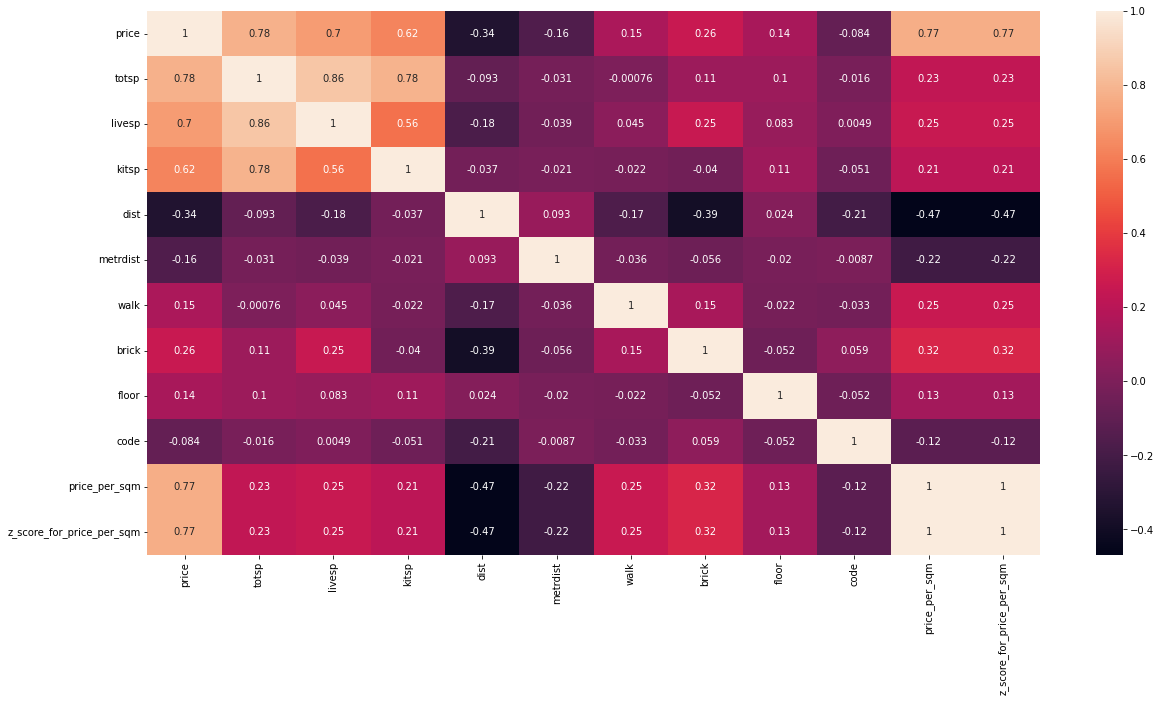

In [11]:
corr_matrix = df3.corr()
sns.heatmap(corr_matrix, annot=True)

# We have to remove features with correlation coefficient >0.7 to avoid multicollinearity

In [12]:
df3 = df3.drop(['z_score_for_price_per_sqm','livesp', 'kitsp', 'price_per_sqm'], axis = 1)

<AxesSubplot:xlabel='price', ylabel='totsp'>

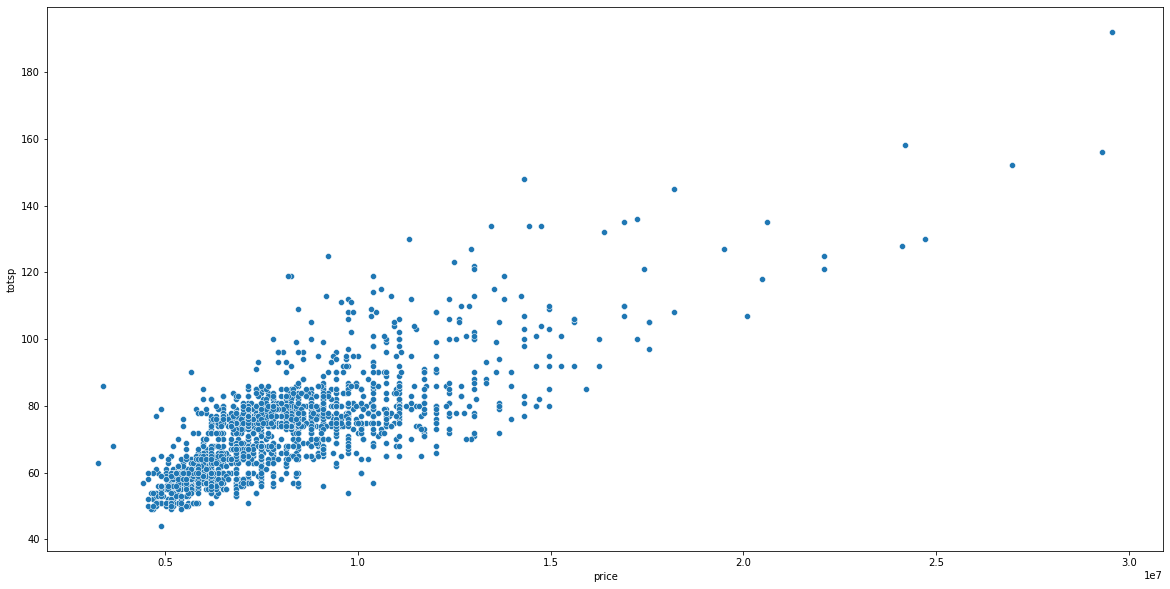

In [13]:
sns.scatterplot(data = df3, x = 'price', y = 'totsp')

<AxesSubplot:>

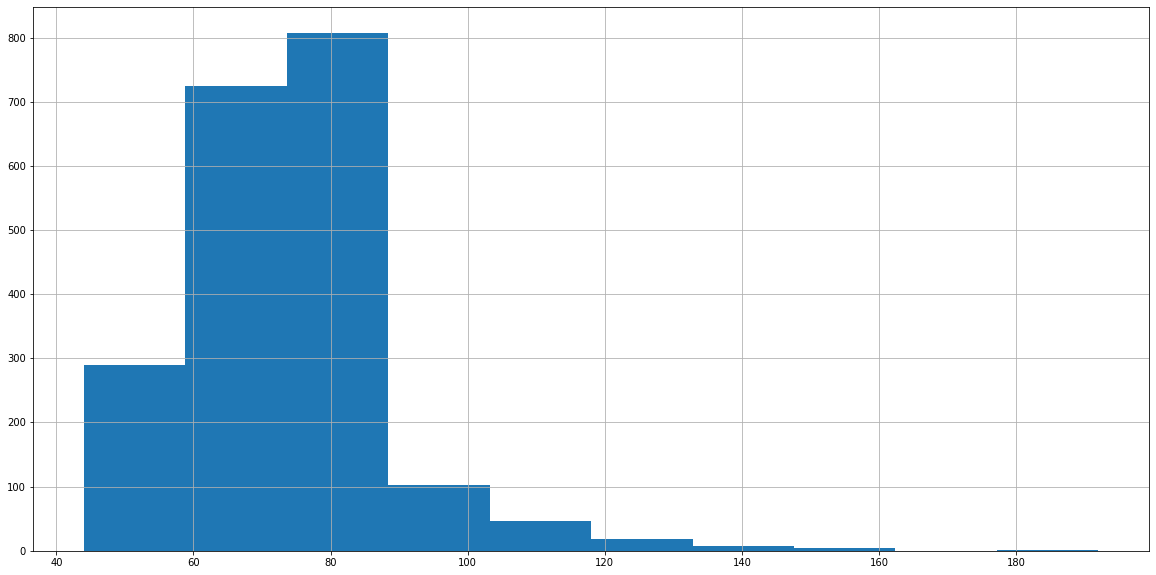

In [14]:
df3.totsp.hist()

# Here we found heteroscedasticity. We can fix this with feature transformation and box-cox or log transformation

In [15]:
#from scipy.special import boxcox

In [16]:
#transformed_price = stats.boxcox(df3['price'], -0.8180112443983517)

In [17]:
#df3['price'] = transformed_price

In [18]:
df3

,price,totsp,dist,metrdist,walk,brick,floor,code
1,5265000,58,12.5,7,1,1,1,3
2,4875000,44,13.5,7,1,0,1,6
3,8320000,70,14.5,3,1,1,1,3
4,6175000,61,13.5,7,1,0,1,1
6,8905000,76,11.0,7,1,1,1,8
...,...,...,...,...,...,...,...,...
2036,7150000,77,12.0,5,0,0,1,5
2037,6175000,60,9.0,5,0,0,1,4
2038,6175000,60,10.5,5,1,0,1,7
2039,8385000,76,12.5,5,0,0,1,3


<AxesSubplot:xlabel='price', ylabel='totsp'>

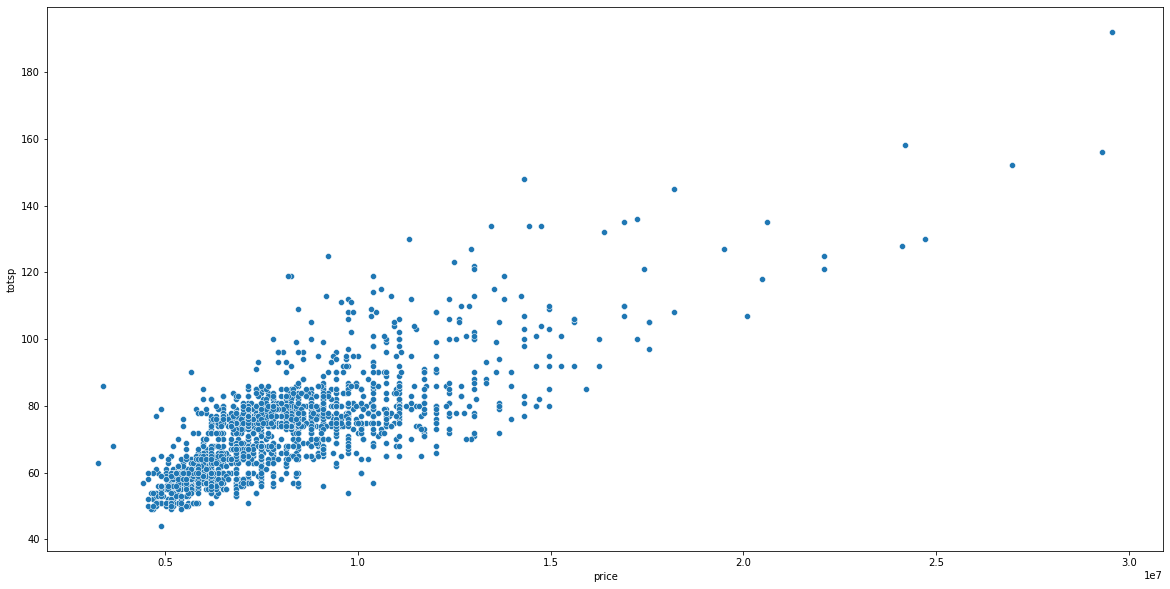

In [19]:
sns.scatterplot(data = df3, x = 'price', y = 'totsp')

In [20]:
df4 = df3.copy()

<AxesSubplot:>

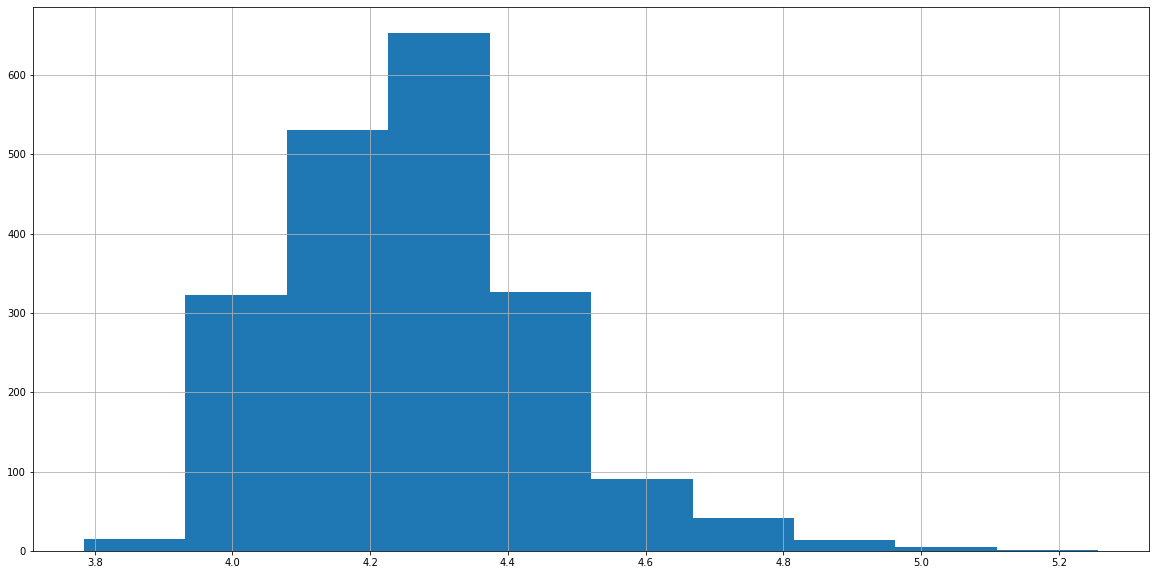

In [21]:
df4['price'] = np.log(df4.price)
df4['totsp'] = np.log(df4.totsp)
df4.totsp.hist()

<AxesSubplot:xlabel='price', ylabel='totsp'>

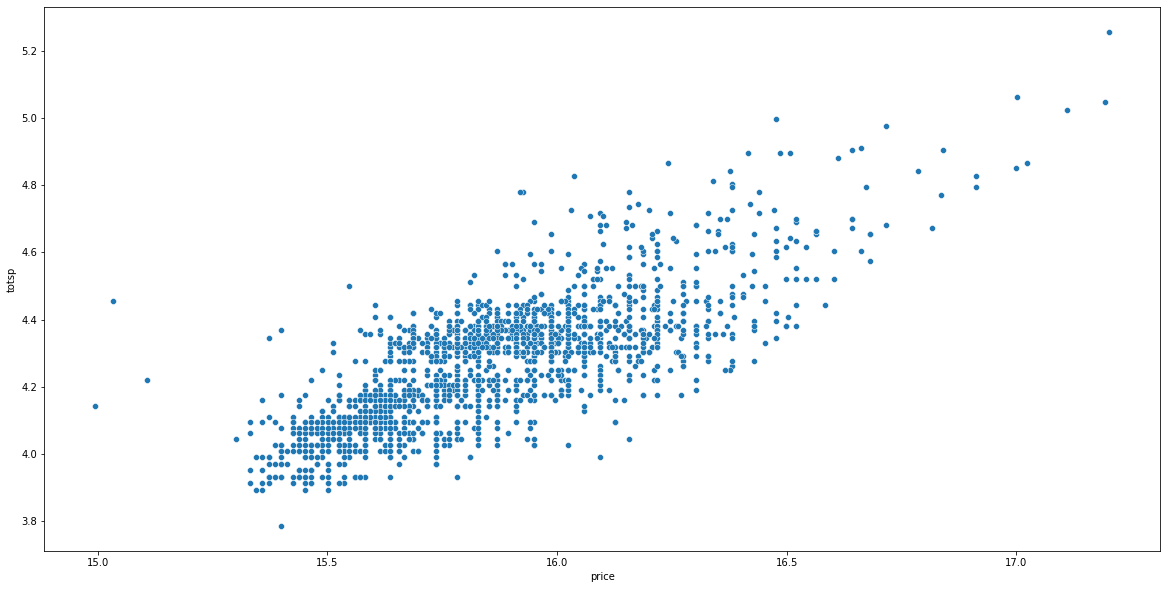

In [22]:
sns.scatterplot(data = df4, x = 'price', y = 'totsp')

In [54]:
df4.to_csv('model_data.csv', index = False)

# I want to try decision tree with gradient boosting(catboost), linear regression and KNN, then choose best model by r2

In [24]:
from sklearn.metrics import r2_score

In [25]:
X = df4.drop('price', axis = 1)
X.head()

,totsp,dist,metrdist,walk,brick,floor,code
1,4.060443,12.5,7,1,1,1,3
2,3.784190,13.5,7,1,0,1,6
3,4.248495,14.5,3,1,1,1,3
4,4.110874,13.5,7,1,0,1,1
6,4.330733,11.0,7,1,1,1,8


In [26]:
y = df4['price']
y.head()

1    15.476592
2    15.399631
3    15.934173
4    15.636019
6    16.002123
Name: price, dtype: float64

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=11)

In [29]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

In [30]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()

In [31]:
from catboost import CatBoostRegressor
catboost = CatBoostRegressor(random_seed = 1, loss_function = 'RMSE', boosting_type= 'Ordered', use_best_model = True)

# Linear Regression

For linear regression we have to standardize our data

In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
scaler = StandardScaler()

scaler.fit(X_train)

StandardScaler()

<AxesSubplot:>

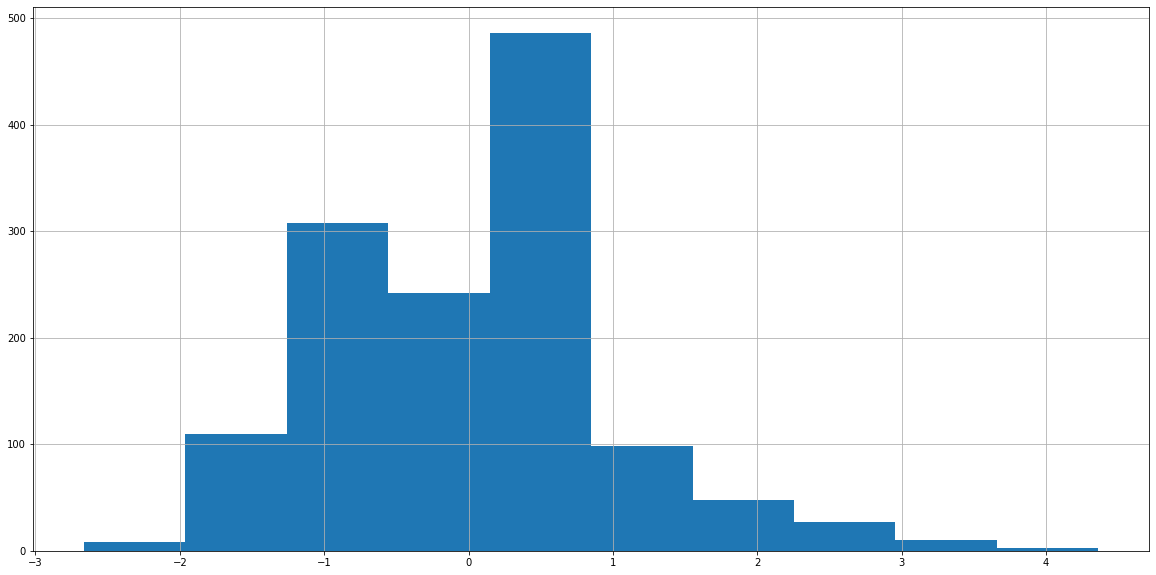

In [34]:
X_train_std = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
X_train_std.totsp.hist()

In [35]:
lin_reg.fit(X_train_std, y_train)

LinearRegression()

In [36]:
pred_train = lin_reg.predict(X_train_std)
pred_test = lin_reg.predict(X_test_std)

print(f'Train R2 : {r2_score(y_train, pred_train): .2f}')
print(f'Test R2 : {r2_score(y_test, pred_test): .2f}')

Train R2 :  0.74
Test R2 :  0.75


# KNN

For KNN model we have to normalize our data

In [37]:
from sklearn.preprocessing import MinMaxScaler

In [38]:
mms = MinMaxScaler()

mms.fit(X_train) 

MinMaxScaler()

In [39]:
X_train_norm = pd.DataFrame(mms.transform(X_train), columns = X_train.columns)

In [40]:
X_train_norm.describe()

,totsp,dist,metrdist,walk,brick,floor,code
count,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,0.379193,0.577793,0.382207,0.672388,0.317164,0.791045,0.481770
std,0.142355,0.236595,0.200341,0.469518,0.465546,0.406714,0.311030
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.268260,0.428571,0.210526,0.000000,0.000000,1.000000,0.285714
50%,0.406659,0.642857,0.342105,1.000000,0.000000,1.000000,0.571429
75%,0.457803,0.750000,0.473684,1.000000,1.000000,1.000000,0.714286
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
X_test_norm = pd.DataFrame(mms.transform(X_test), columns = X_test.columns)

array([[<AxesSubplot:title={'center':'totsp'}>,
        <AxesSubplot:title={'center':'dist'}>,
        <AxesSubplot:title={'center':'metrdist'}>],
       [<AxesSubplot:title={'center':'walk'}>,
        <AxesSubplot:title={'center':'brick'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'code'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

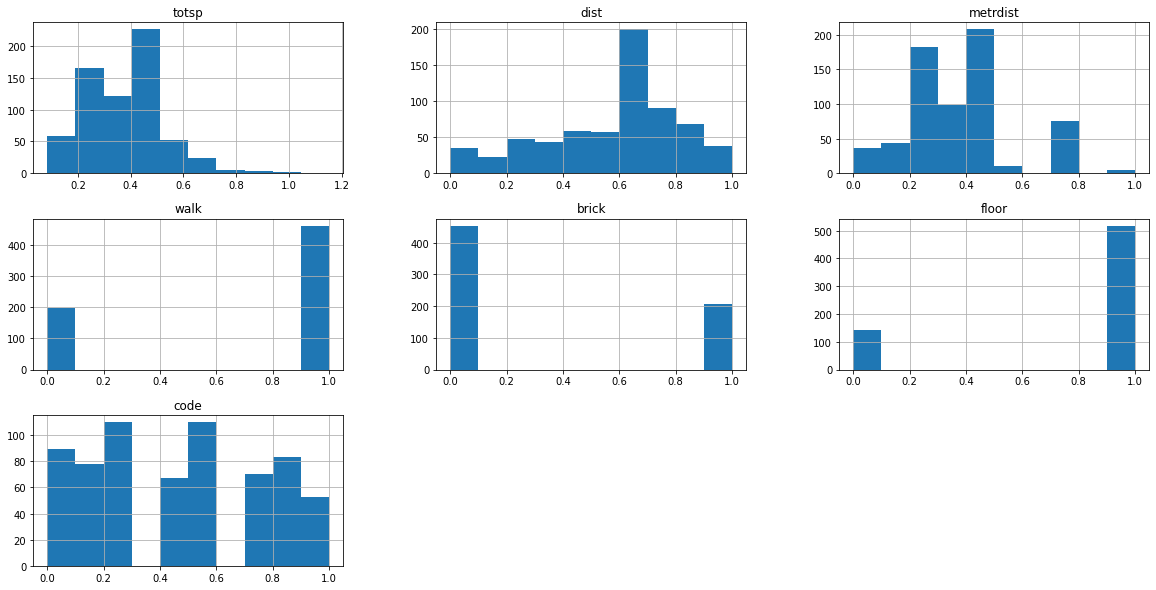

In [42]:
X_test_norm.describe()
X_test_norm.hist()

In [43]:
knn.fit(X_train_norm, y_train)

KNeighborsRegressor()

In [44]:
pred_train_knn = knn.predict(X_train_norm)
pred_test_knn = knn.predict(X_test_norm)

print(f'Train R2: {r2_score(y_train,pred_train_knn): .2f}')
print(f'Test R2: {r2_score(y_test,pred_test_knn): .2f}')

Train R2:  0.77
Test R2:  0.62


# Decision Tree

In [45]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=12)

In [46]:
catboost.fit(X_tr, y_tr, eval_set= (X_val, y_val) , verbose = False, use_best_model = True)

In [47]:
pred_train_cb = catboost.predict(X_train)
pred_test_cb = catboost.predict(X_test)
pred_cb = catboost.predict(X)

print(f'Train R2: {r2_score(y_train,pred_train_cb): .2f}')
print(f'Test R2: {r2_score(y_test,pred_test_cb): .2f}')
print(f'R2: {catboost.score(X, y): .2f}')

Train R2:  0.86
Test R2:  0.78
R2:  0.83


# Decision tree with gradient boosting showed the best results.